<a href="https://colab.research.google.com/github/dchamb16/ComputerVision/blob/master/Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up Google Drive and Kaggle connections

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os;
os.listdir("/content/gdrive/My Drive/MSDS462")

['Kaggle', 'MSDS 462 - Week 1 Discussion.gdoc']

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

!cp /content/gdrive/My\ Drive/MSDS462/Kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d zalando-research/fashionmnist

fashionmnist.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!ls -l /content
!unzip /content/fashionmnist.zip

total 275704
-rw-r--r-- 1 root root  22176691 Sep 21  2019 fashion-mnist_test.csv
-rw-r--r-- 1 root root 133047193 Sep 21  2019 fashion-mnist_train.csv
-rw-r--r-- 1 root root  72114846 Apr 10 15:47 fashionmnist.zip
drwx------ 4 root root      4096 Apr 10 15:46 gdrive
drwxr-xr-x 1 root root      4096 Apr  3 16:24 sample_data
-rw-r--r-- 1 root root   7840016 Sep 21  2019 t10k-images-idx3-ubyte
-rw-r--r-- 1 root root     10008 Sep 21  2019 t10k-labels-idx1-ubyte
-rw-r--r-- 1 root root  47040016 Sep 21  2019 train-images-idx3-ubyte
-rw-r--r-- 1 root root     60008 Sep 21  2019 train-labels-idx1-ubyte
Archive:  /content/fashionmnist.zip
replace fashion-mnist_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
!ls -l /content

total 275704
-rw-r--r-- 1 root root  22176691 Sep 21  2019 fashion-mnist_test.csv
-rw-r--r-- 1 root root 133047193 Sep 21  2019 fashion-mnist_train.csv
-rw-r--r-- 1 root root  72114846 Apr 10 15:47 fashionmnist.zip
drwx------ 4 root root      4096 Apr 10 15:46 gdrive
drwxr-xr-x 1 root root      4096 Apr  3 16:24 sample_data
-rw-r--r-- 1 root root   7840016 Sep 21  2019 t10k-images-idx3-ubyte
-rw-r--r-- 1 root root     10008 Sep 21  2019 t10k-labels-idx1-ubyte
-rw-r--r-- 1 root root  47040016 Sep 21  2019 train-images-idx3-ubyte
-rw-r--r-- 1 root root     60008 Sep 21  2019 train-labels-idx1-ubyte


# Set up python environment by importing libraries and making helper functions

In [0]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
# Function to import and structure data
def import_data(path):
  data = pd.read_csv(path)
  y_data = np.array(data.iloc[:,0])
  x_data = np.array(data.iloc[:,1:])
  x_data = x_data.reshape(-1,28,28,1)
  x_data = x_data / 255.0
  return x_data, y_data

In [0]:
# function to show images
def show_img(x, num_images=16):
    size_img = 28
    plt.figure(figsize=(8,7))
    num_images = num_images
    grid_size = math.ceil(math.sqrt(num_images))
    n_samples = x.shape[0]
    x = x.reshape(n_samples, size_img, size_img)
    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i+1)
        plt.imshow(x[i])
    plt.show()

# Import data and show examples of it

In [0]:
# Import data
train_path = "/content/fashion-mnist_train.csv"
test_path = "/content/fashion-mnist_test.csv"

x_train, y_train = import_data(train_path)
x_test, y_test = import_data(test_path)

In [0]:
#Show data shape and size
n_features_train = x_train.shape[1]
n_samples_train = x_train.shape[0]
n_features_test = x_test.shape[1]
n_samples_test = x_test.shape[0]
print(n_features_train, n_samples_train, n_features_test, n_samples_test)
print(x_train.shape, y_train.shape, x_test.shape)

28 60000 28 10000
(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1)


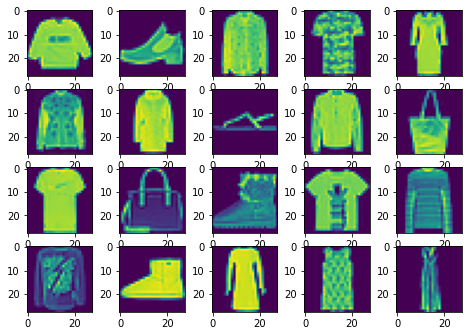

In [0]:
# Show the first x number of images
show_img(x_train,20)

## Image augmentation
Image augmentation allows us to transform the images by rotating, flipping, shifting, and zooming. We do this to make the model more robust by seeing the training images in different aspects with the hopes of making it more generalizable for production level models. 

In [0]:
# Alter the images to make the model more robust
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, 
                         shear_range=0.3, height_shift_range=0.08, 
                         zoom_range=0.08#, horizontal_flip=True,
                         #vertical_flip=True
                         )

test_gen = ImageDataGenerator()

In [0]:
# Run the images through the image augmentor
train_generator = gen.flow(x_train, y_train, batch_size=64)
test_generator = test_gen.flow(x_test, y_test, batch_size=64)

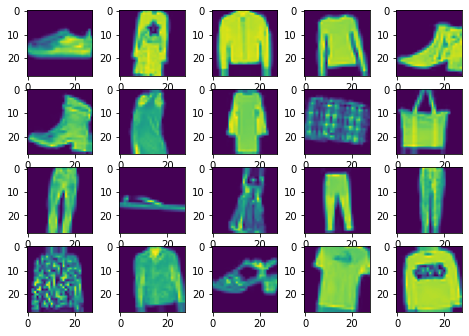

In [0]:
# Show the augmented images
show_img(train_generator[0][0],20)

# Building Models


## Simple model first
I started off by building a an extremely simple model, consisting of a covolutional layer, a max pooling layer, and a dense layer. Also adding a dropout layer for some regularization in the model. With this model, I implement an early stopping callback, allowing the model to stop training if it doesn't improve validation accuracy for 10 epochs. 

In [0]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))

model.add(Dense(10, activation='softmax'))

In [0]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), 
              optimizer='adam', metrics=['accuracy'])

In [0]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10)

In [0]:
history = model.fit(train_generator, epochs=25, steps_per_epoch=60000//128,  
                    validation_data=test_generator, validation_steps=10000//128,
          callbacks=[es])

Epoch 1/25
468/468 [==============================] - 8s 17ms/step - loss: 1.8415 - accuracy: 0.6217 - val_loss: 1.7935 - val_accuracy: 0.6646
Epoch 2/25
468/468 [==============================] - 8s 17ms/step - loss: 1.8130 - accuracy: 0.6502 - val_loss: 1.7728 - val_accuracy: 0.6887
Epoch 3/25
468/468 [==============================] - 8s 17ms/step - loss: 1.8004 - accuracy: 0.6612 - val_loss: 1.7838 - val_accuracy: 0.6750
Epoch 4/25
468/468 [==============================] - 8s 18ms/step - loss: 1.7883 - accuracy: 0.6740 - val_loss: 1.7774 - val_accuracy: 0.6837
Epoch 5/25
468/468 [==============================] - 8s 17ms/step - loss: 1.7865 - accuracy: 0.6743 - val_loss: 1.7655 - val_accuracy: 0.6944
Epoch 6/25
468/468 [==============================] - 8s 17ms/step - loss: 1.7800 - accuracy: 0.6810 - val_loss: 1.7699 - val_accuracy: 0.6891
Epoch 7/25
468/468 [==============================] - 8s 17ms/step - loss: 1.7783 - accuracy: 0.6823 - val_loss: 1.7661 - val_accuracy: 0.6930

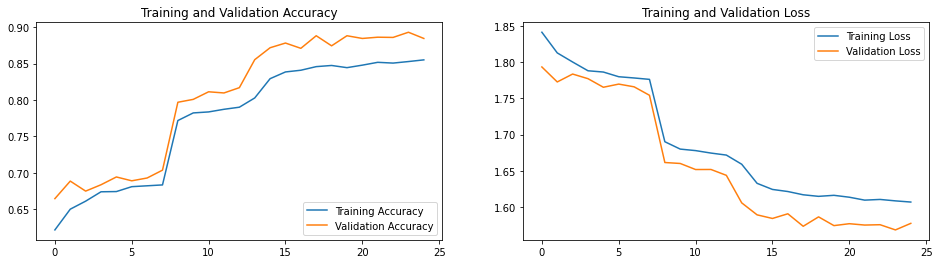

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This model performed pretty well, with a final validation accruacy of 88%. Not bad at all for a simple model. One thing that stood out to me in looking at the above charts is that the model performed steadily worse on training data than on the validation data. That indicates that I could probably make a more complex model to try to get those to balance out. In doing some light research, I think it's acting that way in a good part due to the image augmentation. The test data wasn't augmented, so it seems to be identifying those images better than the augmented training data. 

## LeNet-5
I wanted a slightly more sophisticated model and to learn more about the history of image recognition, which lead me to the LeNet-5 model. It was one of the first breakthroughs in image recognition, with the earliest proposed model of it in 1988. You can read more about the history of LeNet [here](https://en.wikipedia.org/wiki/LeNet). 

This model is adopted from the code found [here](http://euler.stat.yale.edu/~tba3/stat665/lectures/lec18/notebook18.html). Slight changes have been made to conform to newer versions of tensorflow/keras, but it largly remains the same. 

In [0]:
np.random.seed(1000)
le = Sequential()

le.add(Conv2D(6, (5, 5), activation='sigmoid', 
                 input_shape=(28,28,1),
                 padding='valid'))
le.add(MaxPooling2D(pool_size=(2,2)))

le.add(Conv2D(16, (5, 5), activation='sigmoid',
                 padding='valid'))
le.add(MaxPooling2D(pool_size=(2,2)))
le.add(Dropout(0.5))

le.add(Conv2D(120, (1,1), padding='valid'))

le.add(Flatten())
le.add(Dense(84, activation='sigmoid'))
le.add(Dense(10, activation = 'softmax'))

In [0]:
le.compile(loss=SparseCategoricalCrossentropy(from_logits=True), 
              optimizer='rmsprop', metrics=['accuracy'])

In [0]:
le_history = le.fit(train_generator, epochs=25, steps_per_epoch=60000//128,
          validation_data=test_generator, validation_steps=10000//128)

Epoch 1/25
468/468 [==============================] - 8s 18ms/step - loss: 2.0550 - accuracy: 0.4195 - val_loss: 1.8566 - val_accuracy: 0.6204
Epoch 2/25
468/468 [==============================] - 8s 18ms/step - loss: 1.8655 - accuracy: 0.6148 - val_loss: 1.7875 - val_accuracy: 0.6873
Epoch 3/25
468/468 [==============================] - 8s 18ms/step - loss: 1.8306 - accuracy: 0.6411 - val_loss: 1.7716 - val_accuracy: 0.6969
Epoch 4/25
468/468 [==============================] - 9s 19ms/step - loss: 1.8125 - accuracy: 0.6552 - val_loss: 1.7563 - val_accuracy: 0.7095
Epoch 5/25
468/468 [==============================] - 8s 18ms/step - loss: 1.7995 - accuracy: 0.6675 - val_loss: 1.7520 - val_accuracy: 0.7141
Epoch 6/25
468/468 [==============================] - 8s 18ms/step - loss: 1.7908 - accuracy: 0.6749 - val_loss: 1.7483 - val_accuracy: 0.7182
Epoch 7/25
468/468 [==============================] - 8s 18ms/step - loss: 1.7851 - accuracy: 0.6798 - val_loss: 1.7365 - val_accuracy: 0.7272

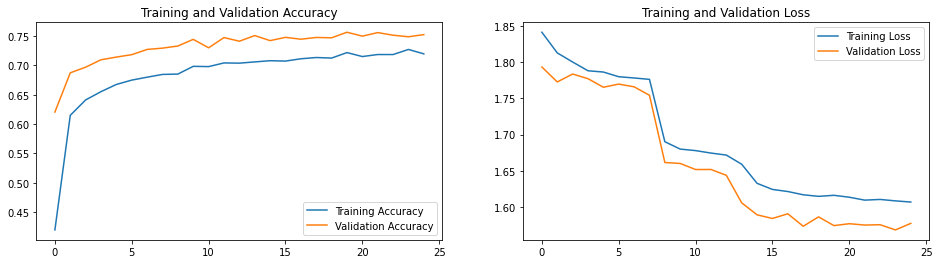

In [0]:
acc = le_history.history['accuracy']
val_acc = le_history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

To my surprise, the LeNet-5 model performed worse than my simple model, with the validation accuracy ending at 75%. I think part of it could be due to using a sigmoid activation function. Now, the ReLU activation function is widely reguareded as one of the better ones to use for hidden layers and the sigmoid is typically reserved for the output layer. At the time of the LeNet proposal, the ReLU activation wasn't around, which is why it wasn't used in the LeNet model. ReLU didn't get introduced in models until 2011. I would expect if the activation functions in this model were changed from sigmoid to ReLU, performance would increase. 

## AlexNet
The AlexNet model has won many accolades over the years in complex image recognition tasks. The paper on AlexNet has been cited over 47,000 times! If you want to learn more about AlexNet and it's history, check out it's wiki page [here](https://en.wikipedia.org/wiki/AlexNet).

The code for this AlexNet was adopted from the same source that the LeNet-5, which is found in this [article](http://euler.stat.yale.edu/~tba3/stat665/lectures/lec18/notebook18.html). 

In [0]:
np.random.seed(1000)

# Init AlexNet Model
alex = Sequential()

# Layer 1
alex.add(Conv2D(96, (11,11), input_shape=(28,28,1),
                padding='same', activation='relu'))
alex.add(MaxPooling2D(pool_size=(2,2)))

# Layer 2
alex.add(Conv2D(256, (5,5), padding='same',
                activation='relu'))
alex.add(MaxPooling2D(pool_size=(2,2)))

# Layer 3
alex.add(ZeroPadding2D((1,1)))
alex.add(Conv2D(512, (3,3), padding='same',
                activation='relu'))

# Layer 4
alex.add(ZeroPadding2D((1,1)))
alex.add(Conv2D(1024, (3,3), padding='same',
                activation='relu'))

# Layer 5
alex.add(ZeroPadding2D((1,1)))
alex.add(Conv2D(1024, (3,3), padding='same',
                activation='relu'))
alex.add(MaxPooling2D(pool_size=(2,2)))
                
# Layer 6
alex.add(Flatten())
alex.add(Dense(3072, activation='relu'))
alex.add(Dropout(0.5))

# Layer 7
alex.add(Dense(4096, activation='relu'))
alex.add(Dropout(0.5))

# Layer 8
alex.add(Dense(10, activation='softmax'))

In [0]:
alex.compile(loss=SparseCategoricalCrossentropy(from_logits=True), 
              optimizer='rmsprop', metrics=['accuracy'])

In [0]:
alex_history = alex.fit(train_generator, epochs=25, steps_per_epoch=60000//128,
          validation_data=test_generator, validation_steps=10000//128)

Epoch 1/25
468/468 [==============================] - 45s 96ms/step - loss: 2.3596 - accuracy: 0.1013 - val_loss: 2.3620 - val_accuracy: 0.0983
Epoch 2/25
468/468 [==============================] - 45s 96ms/step - loss: 2.3605 - accuracy: 0.1006 - val_loss: 2.3586 - val_accuracy: 0.1026
Epoch 3/25
468/468 [==============================] - 45s 96ms/step - loss: 2.3614 - accuracy: 0.0997 - val_loss: 2.3616 - val_accuracy: 0.0993
Epoch 4/25
468/468 [==============================] - 45s 96ms/step - loss: 2.3610 - accuracy: 0.1002 - val_loss: 2.3594 - val_accuracy: 0.1018
Epoch 5/25
468/468 [==============================] - 45s 96ms/step - loss: 2.3620 - accuracy: 0.0991 - val_loss: 2.3568 - val_accuracy: 0.1042
Epoch 6/25
468/468 [==============================] - 45s 96ms/step - loss: 2.3599 - accuracy: 0.1013 - val_loss: 2.3608 - val_accuracy: 0.1004
Epoch 7/25
468/468 [==============================] - 45s 96ms/step - loss: 2.3615 - accuracy: 0.0996 - val_loss: 2.3674 - val_accuracy:

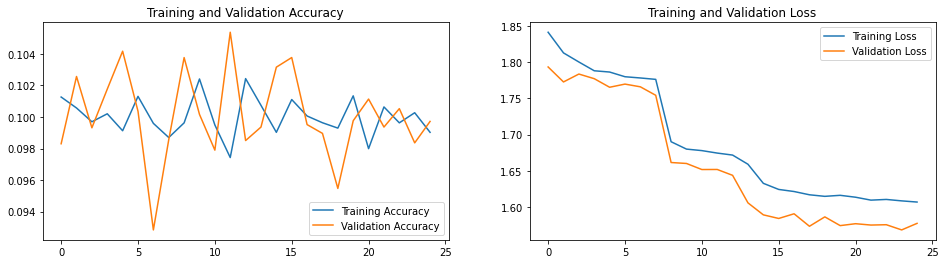

In [0]:
acc = alex_history.history['accuracy']
val_acc = alex_history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Wow, I did not expect it to perform this poorly. Doing some research, it appears that this task is to simple for AlexNet and that it needs higher resolution images to perform well on. Looking at the nodes in the model, the last dense layer has 4,096 nodes in it. That is definitly overkill for the Fashion MNIST dataset. Two options here are to 1) keep the structure, but re-do the number of nodes in layers 2) shelf this model model for this task and save it for more complex tasks. In addition to the poor performance, this model took much longer to train than the other models. This one took around half an hour, compared to around 3-5 minutes for the other two. 